## Hotel and activity coordinates

In [1]:
# 导入必要的库
import gurobipy as gp
import math
from gurobipy import Model, GRB, quicksum, tupledict
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
Start = (50,50) # Hotel coordinates
points = [(Start)] #coordinates of all activities
Start_id = 0 # Hotel idendifier
# points+= [(0,0), (100,100), (100,50), (50,100), (100,0), (0,100)]
points += [(17, 72), (97, 8), (32, 15), (63, 97), (57, 60), (83, 48), (100, 26), (12, 62), (3, 49), (55, 77), 
          (97, 98), (0, 89), (57, 34), (92, 29), (75, 13), (40, 3), (2, 3), (83, 69), (1, 48), (87, 27), 
          (54, 92), (3, 67), (28, 97), (56, 63), (70, 29), (44, 29), (86, 28), (97, 58), (37, 2), (53, 71), 
          (82, 12), (23, 80), (92, 37), (15, 95), (42, 92), (91, 64), (54, 64), (85, 24), (38, 36), (75, 63), 
          (64, 50), (75, 4), (61, 31), (95, 51), (53, 85), (22, 46), (70, 89), (99, 86), (94, 47), (11, 56)]

n = len(points) # total number of nodes

## Distance and time from node i to node j

In [3]:
# A dictionary of distance between two activities (i,j) 
distance = {(i, j):
        math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
        for i in range(n) for j in range(n)}

In [4]:
print(distance[1,0])

39.66106403010388


## Utility or reward to do an activity

In [5]:
reward = {46: 43.15033999478041, 50: 20.948831277616726, 8: 17.263102417797167, 1: 21.18033988749895, 
          32: 27.72004514666935, 23: 30.872991584635255, 34: 29.308440859369416, 12: 38.35909773257803, 
          22: 40.20360331117452, 9: 20.23606797749979, 19: 47.24717771720739, 17: 80.0253925397308, 
          29: 38.176560460191574, 16: 17.584482762024336, 3: 32.86129401644173, 26: 27.65863337187866, 
          39: 27.65863337187866, 41: 33.1049731745428, 6: 36.99351699454112, 36: 26.373825194236886, 
          28: 15.765391263519088, 44: 11.403215514898179, 49: 14.32114465280323, 33: 21.014692853577536, 
          27: 14.939759452009628, 38: 7.728656901081649, 20: 8.990716082598492, 14: 13.929168552452033, 
          7: 26.792291336212188, 2: 33.77246228715468, 31: 26.154320508994672, 42: 19.63014581273465, 
          15: 25.76305461424021, 25: 25.982599071533098, 43: 14.219544457292887, 13: 22.46424919657298, 
          40: 38.17800560721074, 18: 33.3452350598575, 48: 35.510760120453945, 11: 40.626024002111855, 
          47: 39.090644754250064, 4: 20.92577595372165, 21: 22.295630140987, 35: 25.038404810405297, 
          45: 21.28461606164062, 10: 14.57076657157208, 30: 13.395623132202235, 37: 9.307135789365265, 
          24: 5.39834563766817, 5: 15.368833275902082}

# reward = {1:10,2:20,3:30,4:40,5:50,6:60}
reward[Start_id] = 0


## Time windows

In [6]:
early = {46: 0, 50: 0, 8: 12, 1: 22, 32: 39, 23: 53, 34: 69, 12: 91, 22: 109, 9: 111, 19: 156, 17: 191, 29: 194, 16: 209, 3: 227, 26: 236, 39: 255, 41: 274, 6: 292, 36: 300, 28: 308, 44: 312, 49: 322, 33: 333, 27: 337, 38: 340, 20: 346, 14: 354, 7: 373, 2: 388, 31: 399, 42: 408, 15: 425, 25: 434, 43: 439, 13: 456, 40: 466, 18: 490, 48: 502, 11: 530, 47: 541, 4: 551, 21: 563, 35: 576, 45: 584, 10: 591, 30: 598, 37: 600, 24: 603, 5: 615}
late = {46: 35, 50: 41, 8: 53, 1: 63, 32: 80, 23: 94, 34: 110, 12: 132, 22: 150, 9: 152, 19: 197, 17: 232, 29: 235, 16: 250, 3: 268, 26: 277, 39: 296, 41: 315, 6: 333, 36: 341, 28: 349, 44: 353, 49: 363, 33: 374, 27: 378, 38: 381, 20: 387, 14: 395, 7: 414, 2: 429, 31: 440, 42: 449, 15: 466, 25: 475, 43: 480, 13: 497, 40: 507, 18: 531, 48: 543, 11: 571, 47: 582, 4: 592, 21: 604, 35: 617, 45: 625, 10: 632, 30: 639, 37: 641, 24: 644, 5: 656}
# early = {1:0, 2:10, 3:20, 4:30, 5:40, 6:50}
# late = {1:10, 2:20, 3:30, 4:40, 5:50, 6:60}
# early = {}
# late = {}
# for i in range(1,7):
#     early[i]=1
#     late[i]=200
early[0]=1
late[0]=10000000
# print(early)

## Groups of activities

In [7]:
Dining = [i for i in range(len(points)) if i % 3 == 0 and i != 0]
Sightseeing = [i for i in range(len(points)) if i % 3 == 1]
Recreational = [i for i in range(len(points)) if i % 3 == 2]
G = [Dining, Sightseeing, Recreational]

## Budget

In [8]:
B = 300
cost = {e:2 for e in range(1,n)}
cost[0] = 0

In [9]:
print(cost)

{1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 0: 0}


In [10]:
print(reward[1])


21.18033988749895


In [11]:
print(G)

[[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48], [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49], [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50]]


In [12]:
# Plots a TSP solution

def figure_TSP(sol):
    ax = plt.gca() #get cuttent axis
    ax.cla() # clear things for fresh plot

    # change default range
    ax.set_xlim((0, 105))
    ax.set_ylim((0, 105))
    a = []
    b = []
    
    for i in sol:
        a = np.append(a, points[i][1])
        b = np.append(b, points[i][0])
    
    a = np.append(a, points[sol[0]][1])
    b = np.append(b, points[sol[0]][0]) 
    ax.plot(a,b)
    
    for i in sol:
        ax.plot(points[i][1], points[i][0], 'o',color = 'r')
        ax.text(points[i][1], points[i][0], str(i), color='black', fontsize=12)
    plt.show() 

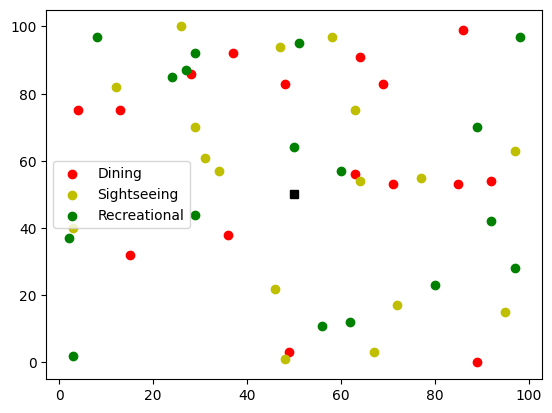

In [13]:
# 绘制输入图形
x = [el[1] for el in points]
y = [el[0] for el in points]


plt.scatter([x[i] for i in Dining], [y[i] for i in Dining], color='r', label='Dining')
plt.scatter([x[i] for i in Sightseeing], [y[i] for i in Sightseeing], color='y', label='Sightseeing')
plt.scatter([x[i] for i in Recreational], [y[i] for i in Recreational], color='g', label='Recreational')

ax = plt.gca()
ax.plot(points[Start_id][1], points[Start_id][0], 's', color='black')

plt.legend()
plt.show()


In [14]:
def heuristic_itinerary(points, distance, start_id, cost, budget, early, late, Dining, Recreational, Sightseeing, reward, n):
    current_position = start_id
    path = [start_id]  # Starting at the hotel
    total_cost = 0
    total_time = 0
    total_reward = reward[start_id]  # Initialize reward with the start point's reward
    visited = {start_id}  # Keep track of visited points
    activities_count = {'Dining': 0, 'Recreational': 0, 'Sightseeing': 0}
    activity_limits = {'Dining': 2, 'Recreational': 1, 'Sightseeing': 1}
    need_dining_next = False  # Flag to enforce a Dining activity next if needed

    # Define activity types based on IDs for easy checking
    activity_type_by_id = {i: 'Dining' if i in Dining else 'Recreational' if i in Recreational else 'Sightseeing' for i in range(1, n)}

    while not all(activities_count[atype] >= limit for atype, limit in activity_limits.items()):
        next_activity = None
        best_value = float('-inf')

        for i in range(1, n):
        
            if i != current_position and i not in visited:
                if need_dining_next and activity_type_by_id[i] != 'Dining':
                    continue  # Skip non-Dining activities if a Dining activity is required next

                if activities_count[activity_type_by_id[i]] >= activity_limits[activity_type_by_id[i]]:
                    continue  # Skip activities exceeding the limit
                


                additional_cost = cost[i] + distance[(current_position, i)]
                additional_time = distance[(current_position, i)]
                if total_cost + additional_cost > budget:
                    continue  # Skip activities that exceed budget

                if early[i] <= total_time + additional_time <= late[i]:
                    value = reward[i] - additional_cost
                    if value > best_value:
                        next_activity = i
                        best_value = value

        # print(need_dining_next)
        # print(next_activity)
        path.append(next_activity)
        visited.add(next_activity)
        total_cost += cost[next_activity] + distance[(current_position, next_activity)]
        total_reward += reward[next_activity]
        current_position = next_activity

        # Update activities count and check if next activity must be Dining
        activities_count[activity_type_by_id[next_activity]] += 1
        if activity_type_by_id[next_activity] != 'Dining':
            need_dining_next = True  # Set the flag if the selected activity isn't Dining
        else:
            need_dining_next = False  # Reset the flag if Dining is chosen

    if current_position != start_id:
        path.append(start_id)
        total_cost += distance[(current_position, start_id)]

    return path, total_reward - total_cost

# 使用正确初始化的数据字典调用函数
path, net_reward = heuristic_itinerary(points, distance, Start_id, cost, budget, early, late, Dining, Recreational, Sightseeing, reward, n)
print("Path:", path)
print("Net Reward:", net_reward)


NameError: name 'budget' is not defined

In [ ]:
# Dynamic programming to solve the TSP (see Excercises week 3)

class Label:
    parent = None
    customer= None
    cost = 0.0
    time = 0.0
    distance = 0
    utility = 0
    def __init__(self, l=None, node=0):
        self.customer = node
        if l:
            self.cost = l.cost + distance[(l.customer, node)] + cost_dict[node]
            self.time = resource_extension_T(l, node)
            self.utility = l.utility + reward[node] - distance[(l.customer, node)] - cost_dict[node]
            self.distance = l.distance + distance[(l.customer, node)]
            
            activity_type = get_activity_type(node)
            if activity_type:  # Ensure activity_type is not None before accessing the dictionary
                self.activities_count = dict(l.activities_count)
                self.activities_count[activity_type] = self.activities_count.get(activity_type, 0) + 1
                self.last_activity = activity_type
            else:
                self.activities_count = dict(l.activities_count)
                self.last_activity = None
            
        else:
            self.activities_count = {'Dining': 0, 'Recreational': 0, 'Sightseeing': 0, 'Other': 0}
            self.last_activity = None
        self.parent = l



def get_activity_type(node):
    if node in Dining:
        return 'Dining'
    elif node in Sightseeing:
        return 'Sightseeing'
    elif node in Recreational:
        return 'Recreational'
    return 'Other'  # Return a default category if no match is found


# Resource extension
def resource_extension_T(l, node):
    """Return resorces used so far"""
    return l.time + distance[(l.customer,node)]

# Feasibilty check
def feasible(l, i):
    """Returns if extending from label l to node i is feasible"""
    # #Is it feasible to go to node i from label l?
    # if l.customer == i:
    #     return False
    # if i !=0 and distance[(l.customer,i)] +l.time < early[i]:
    #     return False
    # if i !=0 and distance[(l.customer,i)] +l.time > late[i]:
    #     return False
    # if l.cost + distance[(l.customer,i)] + cost_dict[i] > B:
    #     return False

    #     # Check for returning to start location with incomplete mandatory activities
    # if i == Start_id:
    #     # Must complete two Dining, one Recreational, and one Sightseeing before returning
    #     if l.activities_count['Dining'] < 2 or l.activities_count['Recreational'] < 1 or l.activities_count['Sightseeing'] < 1:
    #         return False

    # if l.activities_count['Dining'] >= 2 and i != Start_id:
    #     return False
    # if l.customer == Start_id and i == Start_id:
    #     return False
    # if l.last_activity in [Recreational, Sightseeing] and i not in Dining:
    #     return False
    
    # if i in Recreational and l.activities_count['Recreational'] >= 1:
    #     return False
    # if i in Sightseeing and l.activities_count['Sightseeing'] >= 1:
    #     return False

    return True


# alot of acitivity contraints to be added 



#dominance
def dominance(l1,l2):
    """Retuns true if l1 dominates l2"""
    if l1.utility >= l2.utility:
        return True
    return False

def labeling_algorithm():
    l0 = Label()
    M = {(k,i): [] for k in range(n) for i in range(n)}
    M[(0,0)].append(l0)

    for k in range(1, n): 

        ## k is the number of nodes visited
        for i in range(n):
            
            ## i is the current node
            for j in range(1, n):
                
                ## j is the new node to extend to
                if j == i: 
                    # the new node is different than the current node
                    continue
              
                for l in M[(k-1,i)]:
                    #print("mkij", k,i,j)
                    # l is all the labels stored in this bucket
                    if feasible(l,j):
                        l2 = Label(l,j) #extend label
                        dominated = False
                        for l1 in M[(k,j)]:
                            if dominance(l1, l2):
                                dominated = True
                            elif dominance(l2, l1):
                                ## if l1 is dominated then we need to delete l1
                                M[(k,j)].remove(l1)
                            if dominated:
                                break
                        if not dominated:
                            #if l2 is not dominated add to list of labels
                            M[(k,j)].append(l2)       
    return best_label(M)

def best_label(M):
    # 初始化最佳标签和最高效用为负无限大，以便任何实际效用都会更高
    best_l = None
    highest_utility = float('-inf')

    # 遍历字典 M 中的所有标签
    for k in range(1, n):
        for i in range(1, n):
            for label in M[(k, i)]:
                # 检查当前标签的效用是否比已知的最高效用还要高
                if label.utility > highest_utility:
                    best_l = label
                    highest_utility = label.utility

    # 如果找到了最佳标签，则返回
    if best_l is not None:
        print("Best label found with utility: ", highest_utility)
        return best_l
    else:
        print("No valid label found")
        return None

# def best_label(M={}):
#     """Find the label with the shortest path back to the depot """
#     best_l = Label()
#     best_utility = 0
#     for k in range(1,n):
#         for i in range(1,n):
#             for l in M[(k,i)]:
#                 print(l)
#                 a = reward[Start_id] - distance[(l.customer, Start_id)] 
#                 b = reward[Start_id] - distance[(best_l.customer, Start_id)] 
#                 if l.utility + a > best_l.utility +b:
#                     best_l = l
#                     best_utility = l.utility + a
#     print("Solution value: ", best_utility)
#     return best_l
# l = labeling_algorithm() #find the label with the cheapest path

In [1]:
# Number of points or activities
n = len(points)  # Assuming 'points' contains all your locations including the hotel
x = np.zeros(n, dtype=int)
# Transition variables between activities
# Binary variable for each pair of activities, 1 if transitioning directly from i to j, 0 otherwise
y = np.zeros((n, n), dtype=int)
t = np.zeros(n, dtype=float)

def evaluate_objective(x, y, reward, cost, distance):
    total_rewards = sum(reward[i] * x[i] for i in range(len(x)))
    total_activity_costs = sum(cost[i] * x[i] for i in range(1, len(x)))
    total_transition_costs = sum(distance[(i, j)] * y[i, j] for i in range(len(y)) for j in range(len(y[i])) if i != j)
    return total_rewards - total_activity_costs - total_transition_costs
def apply_no_self_loop_constraint(y):
    for i in range(len(y)):
        y[i, i] = 0

def enforce_flow_conservation(y):
    n = len(y)
    for i in range(n):
        inflow = sum(y[j][i] for j in range(n))
        outflow = sum(y[i][j] for j in range(n))
        if inflow != outflow:
            return False  # Constraint violated
    return True  # All constraints satisfied

def enforce_selection_consistency(x, y):
    n = len(x)
    for i in range(n):
        # Check if the sum of y[i, j] for all j equals x[i]
        if sum(y[i][j] for j in range(n)) != x[i]:
            return False
        # Check if the sum of y[j, i] for all j equals x[i]
        if sum(y[j][i] for j in range(n)) != x[i]:
            return False
    return True  # All constraints satisfied

def check_budget_constraint(x, y, cost, distance, B):
    total_activity_costs = sum(cost[i] * x[i] for i in range(1, len(x)))
    total_transition_costs = sum(distance[(i, j)] * y[i, j] for i in range(len(y)) for j in range(len(y[i])) if i != j)
    return (total_activity_costs + total_transition_costs) <= B

def check_time_windows(x, t, early, late):
    for i in range(1, len(x)):
        if x[i] == 1:
            if not (early[i] <= t[i] <= late[i]):
                return False
    return True

def check_transition_times(x, y, t, distance):
    for i in range(len(y)):
        for j in range(len(y[i])):
            if i != j and y[i][j] == 1:
                if i == 0:
                    if t[j] < 0 + distance[(i, j)]:
                        return False
                else:
                    if t[j] < t[i] + distance[(i, j)]:
                        return False
    return True

def check_dining_follows(x, y, Recreational, Sightseeing, Dining):
    for i in range(1, len(x)):
        if i in Recreational or i in Sightseeing:
            if x[i] == 1:  # If activity i is selected
                if sum(y[i][j] for j in Dining) < 1:
                    return False
    return True

def check_one_activity_per_group(x, group):
    return sum(x[i] for i in group) == 1

def check_two_dining_activities(x, Dining):
    return sum(x[i] for i in Dining) == 2

def check_start_from_hotel(y, Start_id):
    return sum(y[Start_id][j] for j in range(len(y))) == 1

def check_end_at_hotel(y, Start_id):
    return sum(y[i][Start_id] for i in range(len(y))) == 1


NameError: name 'points' is not defined

In [ ]:
apply_no_self_loop_constraint(y)
# Example use of constraint checks:
flow_ok = enforce_flow_conservation(y)
selection_ok = enforce_selection_consistency(x, y)
budget_ok = check_budget_constraint(x, y, cost, distance, B)
time_window_ok = check_time_windows(x, t, early, late)
transition_time_ok = check_transition_times(x, y, t, distance)
dining_follows_ok = check_dining_follows(x, y, Recreational, Sightseeing, Dining)
recreational_ok = check_one_activity_per_group(x, Recreational)
sightseeing_ok = check_one_activity_per_group(x, Sightseeing)
dining_ok = check_two_dining_activities(x, Dining)
start_from_hotel_ok = check_start_from_hotel(y, Start_id)
end_at_hotel_ok = check_end_at_hotel(y, Start_id)

In [ ]:
def random_initial_solution(n, Dining, Recreational, Sightseeing):
    x = np.zeros(n, dtype=int)
    y = np.zeros((n, n), dtype=int)
    t = np.zeros(n, dtype=float)
    
    # Randomly select one activity from each category, except Dining where we select two
    selected_recreational = random.choice(Recreational)
    selected_sightseeing = random.choice(Sightseeing)
    selected_dining = random.sample(Dining, 2)

    activities = [selected_recreational, selected_sightseeing] + selected_dining
    for act in activities:
        x[act] = 1
    
    # Create a simple valid route starting and ending at the hotel
    route = [0] + activities + [0]
    for i in range(len(route) - 1):
        y[route[i], route[i + 1]] = 1
        t[route[i + 1]] = t[route[i]] + distance[(route[i], route[i + 1])]  # Simplistic time calculation

    return x, y, t

def valid_solution(x, y, t):
    if not all([check_start_from_hotel(y, Start_id),
                check_end_at_hotel(y, Start_id),
                enforce_flow_conservation(y),
                enforce_selection_consistency(x, y),
                check_budget_constraint(x, y, cost, distance, B),
                check_time_windows(x, t, early, late),
                check_transition_times(x, y, t, distance),
                check_dining_follows(x, y, Recreational, Sightseeing, Dining),
                check_one_activity_per_group(x, Recreational),
                check_one_activity_per_group(x, Sightseeing),
                check_two_dining_activities(x, Dining)]):
        return False
    return True

def vns(n, Dining, Recreational, Sightseeing, max_iterations=100):
    x, y, t = random_initial_solution(n, Dining, Recreational, Sightseeing)
    
    if not valid_solution(x, y, t):
        return "No valid initial solution found."

    current_best = (x, y, t)
    iteration = 0

    while iteration < max_iterations:
        k = 1  # Initial neighborhood size
        while k < 4:  # Increase the neighborhood size
            new_x, new_y, new_t = perturb_solution(current_best, k, n, Dining, Recreational, Sightseeing)
            if valid_solution(new_x, new_y, new_t):
                current_best = (new_x, new_y, new_t)
                k = 1  # Reset neighborhood size if an improvement is found
            else:
                k += 1
        iteration += 1
    
    return current_best

def perturb_solution(solution, k, n, Dining, Recreational, Sightseeing):
    x, y, t = solution
    # Implement a method to perturb the solution based on neighborhood size `k`
    # This could involve swapping activities, changing the order, etc.
    # Make sure to maintain the validity of the solution structure (especially with y and t)

    # For simplicity, here's a placeholder for how you might start:
    if k == 1:  # Simple perturbation
        pass
    elif k == 2:  # More complex perturbation
        pass
    elif k == 3:  # Even more complex perturbation
        pass

    return x, y, t
# Run the VNS algorithm
best_solution = vns(n, Dining, Recreational, Sightseeing)
print("Best Solution Found:", best_solution)